In [1]:
import pandas as pd
import os
import time
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Masking, LSTM, Dense

from LSTM.naive_preprocess import process_data
from LSTM.LSTM_classifier import LSTMclf
from LSTM.Config import Options as opts
from tools.tools import evaluate

#### Load and preprocess data

In [2]:
pos_train_path = os.path.join('Data', 'pos_train.csv')
pos_train = pd.read_csv(pos_train_path)

neg_train_path = os.path.join('Data', 'neg_train.csv')
neg_train = pd.read_csv(neg_train_path)

pos_test_path = os.path.join('Data', 'pos_test.csv')
pos_test = pd.read_csv(pos_test_path)

neg_test_path = os.path.join('Data', 'neg_test.csv')
neg_test = pd.read_csv(neg_test_path)

train_data, train_labels = process_data(pos_train, neg_train)
input_shape = np.array(train_data).shape
test_data, test_labels = process_data(pos_test, neg_test)

print(f'Train shape: {input_shape} Test shape: {np.array(test_data).shape}')

training visits: 717
training visits: 74
Train shape: (717, 500, 5) Test shape: (74, 500, 5)


#### Instantiate our model

In [3]:
clf = LSTMclf(input_shape)
clf.model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 500, 5)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 200)               164800    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 165,001
Trainable params: 165,001
Non-trainable params: 0
_________________________________________________________________


#### 5 fold CV on different batch sizes

Accumulate the results for each to compare later

In [4]:
batch_sizes = [32, 64, 128, 256]
results = []
start_time = time.time()
for batch_size in batch_sizes:
    print(f'Cross validation with batch size {batch_size}.')
    metrics = clf.trainCV(train_data, train_labels, 5, batch_size, 10)
    metrics['batch_size'] = batch_size
    results.append(metrics)

    model_path = os.path.join('./LSTM/results/naive_results', f'LSTM{batch_size}.h5')
    clf.model.save(model_path)

elapsed_time = time.time() - start_time
results_df = pd.DataFrame(results, columns=['batch_size', 'accuracy', 'precision', 
                                            'recall', 'f1', 'auc'])
hr = int(elapsed_time // 3600)
elapsed_time %= 3600
min = int(elapsed_time // 60)
sec = elapsed_time % 60
print(f'Total time: {hr:02d}:{min:02d}:{sec:0.2f}\n')

result_path = os.path.join('./LSTM/results/naive_results', 'results.csv')
results_df.to_csv(result_path)
results_df

Cross validation with batch size 32.
Beginning training LSTM with 5-fold validation...
Epoch 1/10
18/18 [==============================] - 15s 657ms/step - loss: 0.6306 - accuracy: 0.6638
Epoch 2/10
18/18 [==============================] - 12s 640ms/step - loss: 0.5797 - accuracy: 0.7073
Epoch 3/10
18/18 [==============================] - 11s 596ms/step - loss: 0.5613 - accuracy: 0.7108
Epoch 4/10
18/18 [==============================] - 11s 599ms/step - loss: 0.5396 - accuracy: 0.7369
Epoch 5/10
18/18 [==============================] - 12s 678ms/step - loss: 0.5135 - accuracy: 0.7561
Epoch 6/10
18/18 [==============================] - 13s 719ms/step - loss: 0.5041 - accuracy: 0.7648
Epoch 7/10
18/18 [==============================] - 12s 683ms/step - loss: 0.5052 - accuracy: 0.7439
Epoch 8/10
18/18 [==============================] - 12s 657ms/step - loss: 0.5044 - accuracy: 0.7596
Epoch 9/10
18/18 [==============================] - 12s 679ms/step - loss: 0.4611 - accuracy: 0.7857
Epoc

,batch_size,accuracy,precision,recall,f1,auc
0,32,0.685315,0.710692,0.629526,0.667651,0.685550
1,64,0.637762,0.668919,0.551532,0.604580,0.638126
2,128,0.697902,0.718654,0.654596,0.685131,0.698085
3,256,0.581818,0.588757,0.554318,0.571019,0.581934


#### Reload the model that looks best and evaluate against our held out test data

              precision    recall  f1-score   support

           0       0.97      0.81      0.88        37
           1       0.84      0.97      0.90        37

    accuracy                           0.89        74
   macro avg       0.90      0.89      0.89        74
weighted avg       0.90      0.89      0.89        74



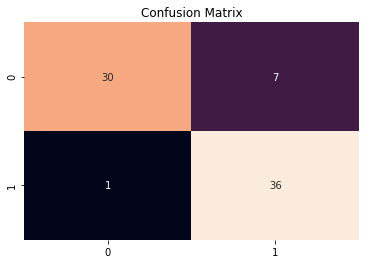

In [5]:
model_path = os.path.join('./LSTM/results/naive_results', 'LSTM128.h5')
clf = load_model(model_path, compile=False)

pred = clf.predict(test_data).reshape(-1)
pred = (pred > 0.5).astype(int)
metrics = evaluate(test_labels, pred)

print(classification_report(test_labels, pred))
cm = confusion_matrix(test_labels, pred)
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.show()